# ÉCOLE IVADO/MILA EN APPRENTISSAGE PROFOND
# SESSION D' AUTOMNE 2018 
# Tutoriel : Réseaux convolutifs

## Auteurs: 

Margaux Luck <margaux.luck@rd.mila.quebec>

Jeremy Pinto <jeremy.pinto@rd.mila.quebec>

Mathieu Germain <mathieu.germain@rd.mila.quebec>

## Préface

Ce tutoriel à pour but d'introduire les concepts fondamentaux sur les réseaux de neurones convolutifs à l'aide d'exemples concrets.

# Initialisation

Avant de commencer, nous devons nous assurer d'installer les librairies nécessaires pour le tutoriel à l'aide de `pip`.  Pour se faire, exécutez la cellufle suivante en la sélectionnant et en cliquant `shift`+`Enter`. Ceci peut prendre quelques minutes.

In [1]:
!pip install torch torchvision Pillow matplotlib

Afin de vous assurer que l'installation s'est bien faite, importez toutes les libraries et modules dont nous nous servirons pour ce tutoriel en exécutant la prochaine cellule:

In [2]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Version de torch: ", torch.__version__)
print("GPU disponible: {}".format(use_gpu))

Version de torch:  1.6.0
GPU disponible: False


# Le jeu de données MNIST
MNIST est le **jeu de données de référence de classification** utilisé en **vision par ordinateur**. Il est hébergé sur <a href="http://yann.lecun.com/exdb/mnist/">le site de Yann LeCun</a>. Il se compose d'**images de chiffres manuscripts**. Quelques exemples sont données ci-dessous :

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mnist.png?raw=true)

Il inclut également des **étiquettes de classes pour chaque image**, indiquant à quel chiffre elle correspond. Par exemple, les étiquettes des images ci-dessus sont 5, 0, 4 et 1.

Il se compose de **60 000 exemples d'entraînement** et de **10 000 exemples de test**. Les images sont toutes de la même taille (**28x28 pixels**). Chaque pixel est représenté par un chiffre entre 0 et 255 indiquant une nuance de gris. En fonction des modèles que nous allons tester les images seront utilisées telles quelles ou bien aplaties.

Les classes sont balancées, c'est à dire qu'il y a une proportion plus ou moins égale des différents chiffres dans notre jeu de données.

## Objectif

Nous cherchons à concevoir un algorithme pour classifier ces chiffres correctement. Dans notre cas, nous utiliserons comme entrée l'intensité de tous les pixels d'une image et essayerons de prédir la valeur du chiffre en question. Ce problème peut se résumer à:

`f(image) = chiffre prédit`

où `f` est une fonction quelconque. 

Dans ce tutoriel, nous considérerons un **perceptron multi-couche** ainsi qu'un **réseau de neurones convolutif**. Ces fonctions prennent en entrée l'intensité des pixels et effectuent des opérations mathématiques sur ces valeurs. La valeur de retour de la fonction est un vecteur de taille *1xN* où chaque entrée correspond à la probabilité que le chiffre en question soit ce chiffre. La somme de toutes ces valeurs est nécessairement de 1. Notre prédiction finale est l'entrée pour laquelle la probabilité est maximale. Par exemple, la prédiction

`[0.8, 0.1, 0, 0, 0, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]`

indique à 80% de chances qu'il s'agit du chiffre 0.

Pour chacun de ces modèles, nous chercherons à "apprendre" la meilleure solution. Pour se faire, nous commencerons à partir d'une solution aléatoire et chercherons à converger vers une solution optimale. À chaque itération, nous comparons les résultats de notre prédiction à la réelle valeure et ajustons nos modèles par la suite jusqu'à ce que nous satisfaisions un certain critère d'arret

## Télécharger les données et créer le chargeur de données

Avant de commencer, nous devons nous assurer d'avoir accès aux données de MNIST. Nous utiliserons les fonctions natives à PyTorch pour les récupérer.

### Boîte à outils
**Rappel:** Dans PyTorch, il existe des fonctions pour charger, mélanger et augmenter les données. 

Une façon simple de charger les données dans PyTorch est : 
<ul>
<li>D'utiliser une classe enfant de <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset">`torch.utils.data.Dataset`</a> où les méthodes `__getitem__` et `__len__` sont à compléter.</li>
<li>D'utiliser la classe <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader">`torch.utils.data.DataLoader`</a> pour lire et mettre en mémoire les données.</li>
</ul>


Par chance, dans pytorch, il existe déjà une classe enfant de Dataset pour utiliser MNIST : <a href="http://pytorch.org/docs/master/torchvision/datasets.html#mnist">`torchvision.datasets.MNIST`</a>.

<a href="http://pytorch.org/docs/master/torchvision/datasets.html">D'autres jeux de données sont aussi disponibles.</a>

**Remarque:** <a href="http://pytorch.org/docs/master/tensors.html#torch.Tensor.view">`torch.Tensor.view()`</a> renvoie un nouveau tenseur avec les mêmes données que le tenseur d'origine mais avec une taille différente. Cela peut donc être utilisé pour aplatir une image, par exemple.

In [4]:
import numpy as np
import random
import torch
from torch.utils.data import sampler, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


manualSeed = 1234
use_gpu = torch.cuda.is_available()

# Fixer la graine aléatoire
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_gpu:
   torch.cuda.manual_seed_all(manualSeed)

class ChunkSampler(sampler.Sampler):
    """
    Échantillonne les éléments de façon séquentielle 
        à partir d'un certain décalage.
    De : https://github.com/pytorch/vision/issues/168
    
    Paramètres
    ----------
    num_samples : int
      # Nombre de points de données souhaités
    start : int
      Décalage où nous devrions commencer à choisir
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


train_dataset = MNIST(root='../data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

test_dataset = MNIST(root='../data', 
                     train=False, 
                     transform=transforms.ToTensor())

train_dataset_sizes = len(train_dataset)
num_train_samples = int(0.8 * train_dataset_sizes)
num_valid_samples = train_dataset_sizes - num_train_samples
num_test_samples = len(test_dataset)

print("# d'exemples d'entraînement: {}".format(num_train_samples))
print("# d'exemples de validation: {}".format(num_valid_samples))
print("# d'exemples d'évaluation: {}".format(num_test_samples))

batch_size = 100

train_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(num_train_samples, 0),
                          batch_size=batch_size, 
                          shuffle=False)

valid_loader = DataLoader(dataset=train_dataset,
                          sampler=ChunkSampler(
                              num_valid_samples, num_train_samples),
                          batch_size=batch_size, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# d'exemples d'entraînement: 48000
# d'exemples de validation: 12000
# d'exemples d'évaluation: 10000


Visualisons les données d'entraînement !

Taille des entrées: torch.Size([100, 1, 28, 28])
Taille des classes: torch.Size([100])


Visualisons la première image:


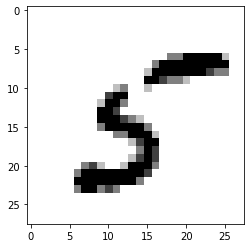

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

inputs, classes = next(iter(train_loader))

print('Taille des entrées: {}'.format(inputs.size()))
print('Taille des classes: {}'.format(classes.size()))

# Random image of the batch
img1 = 255 - inputs[np.random.randint(len(inputs))] * 255

# Plot the image
print('\n\nVisualisons la première image:')
img1 = img1.numpy()[0, :, :]
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.grid(False)
plt.show()


# CPU ou GPU
**Rappel:** <a href="http://pytorch.org/docs/master/cuda.html#module-torch.cuda">`torch.cuda`</a> est une librairie qui permet d'utiliser des GPUs pour effectuer les calculs sur des tenseurs. La librairie inclut des tenseurs de type CUDA qui ont les mêmes fonctions que les tenseurs réguliers mais qui utilisent des GPUs pour leurs calculs, au lieu d'un CPU. <a href="http://pytorch.org/docs/master/cuda.html#torch.cuda.is_available">`torch.cuda.is_available()`</a> retourne un booléen indiquant si CUDA est présentement disponible. Pour passer d'un tenseur de type CPU à un tenseur de type GPU, il suffit de lui ajouter `.to("cuda:0")`.

Pour plus d'informations sur comment utiliser les GPU sur colab, vous pouvez lire ce [tutoriel](https://colab.research.google.com/drive/1y3ZE4m-D7lPoMzsypSEXessYmjWfKGqD#scrollTo=3IEVK-KFxi5Z).


In [6]:
use_gpu = torch.cuda.is_available()

print("GPU disponible: {}".format(use_gpu))

GPU disponible: False


# Le perceptron multi-couche
Un perceptron multi-couche est un réseau de neurones à propagation avant simple. Il prend en entrée les images, les transforme à travers une série de couches cachées et finalement donne une sortie. Cette sortie correspond à la probabilité d'appartenance à l'une ou l'autre des classes de la cible.

Par exemple, si on regarde un perceptron multi-couche qui classifie des images de chiffres du jeu de données MNIST :

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/mlp.png?raw=true)

La procédure d'apprentissage typique pour ce modèle consiste à :
<ul>
<li>Définir l'architecture du réseau. Cela définira les paramètres (poids et biais) du réseau.</li>
<li>Définir la fonction de coût et l'optimiseur.</li>
<li>Entraîner le réseau.</li>
<li>Tester le réseau.</li>
</ul>

Notez que cette procèdure est valable pour l'entraînement de tout type de réseau de neurones profonds.

### Boîte à outils

Rappelons qu'un réseau de neurones profond peut être construit en utilisant la librairie <a href="http://pytorch.org/docs/master/nn.html">`torch.nn`</a>. `nn` travaille avec <a href="http://pytorch.org/docs/master/autograd.html">`torch.autograd`</a> pour définir et différencier les modèles.

## Définir l'architecture du réseau
### Boîte à outils

Pour définir l'architecture du réseau en pytorch il faut créer une classe enfant de la classe parent <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Module">`torch.nn.Module`</a> où les méthodes suivantes sont à compléter :
<ul>
<li>La méthode `__init__` qui définit les couches. </li>
<li>La méthode `forward(input)` qui retourne l'`output` (la sortie).</li>
</ul>

Pour construire les couches de l'`__init__` du perceptron multi-couche, les classes suivantes peuvent être utilisées :
<ul>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a> qui applique une transformation linéaire aux données d'entrée : y = Ax + b.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.ReLU">`torch.nn.Relu()`</a> qui applique la fonction Relu éléments par éléments : Relu(x) = max(0, x).</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Softmax">`torch.nn.Softmax(dim)`</a> qui applique la fonction Sofmax à un tenseur d'entrée à n-dimensions en le normalisant de tel sorte que les éléments de tenseur de sortie à n-dimensions soient dans l'intervalle [0, 1] et somment à 1.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Sequential">`torch.nn.sequential`</a>  qui est un conteneur séquentiel dans lequel les modules sont ajoutés dans l'ordre dans lequel ils sont passés au constructeur.</li>
</ul>

Dans `forward(input)` on applique aux données d'entrée les différentes couches définies dans `__init__` les unes après les autres.

Enfin, `model.to(device)` permet de passer le modèle sur GPU lorsque disponible.

## Implémentation

### Modèle

Nous voulons implémenter un modèle à trois couches avec la non-linéarité ReLU entre chaque couche.

In [7]:
import torch.nn as nn
import copy

input_size = 784
hidden_size = 500
num_classes = 10

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU())
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, num_classes))
    
    def forward(self, x):        
        
        out = self.hidden_layer(x)
        
        out = self.output_layer(out)
        
        return out

model = MLP(input_size, hidden_size, num_classes)
# envoyer le modèle au GPU
model = model.to(device)

print(model)

print("\n\n# paramètres: ", sum([param.nelement() for param in model.parameters()]))

# Sauvegarder les poids initiaux du modèle
init_model_wts = copy.deepcopy(model.state_dict())

MLP(
  (hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=500, out_features=10, bias=True)
  )
)


# paramètres:  648010



### Nombre de paramètres

En entrée, nous avons 28x28 pixels applatis, donc un vecteur de taille 1x784. Afin de passer à une seconde couche de taille 500, nous avons besoin de 500 vecteurs de poids 1x784, donc 784\*500, ainsi que de 500 biais, donc 785\*500 total. Continuant cette logique, nous avons un nombre total de paramètres de:

`785*500 + 501*500 + 501*10 = 648010` 

## Définir la fonction de coût et l'optimiseur
### Boîte à outils
De nombreuses fonctions de coût et optimiseurs sont disponibles dans Pytorch. 

Rappelons qu'une fonction de coût $J(\theta) = L(x, y, \theta)$ prend en entrée le couple (prédiction, cible) et calcule une valeur qui estime la distance entre la prédiction et la cible. L'optimiseur dans le cas de la descente de gradient stochastique, ou Stochastic Gradient Descent (SGD), minimise la fonction de coût $J(\theta)$ paramétrisée par les poids du modèle $\theta \in \mathbb{R}^d$ en mettant à jour les poids itérativement suivant cette règle simple : `poids = poids - pas_d_apprentissage * gradient`.

Un choix commun pour un problème de classification (notre cas) est d'utiliser les classes suivantes :
<ul>
<li>**Fonction de coût :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. L'entropie croisée est souvent utilisée en optimisation. Elle permet de comparer une distribution $p$ avec une distibution de référence $t$. Elle est minimum lorsque $t=p$. Sa formule pour la calculer entre la prédiction et la cible est : $-\sum_j t_{ij} \log(p_{ij})$ où $p$ est la prédiction, $t$ la cible, $i$ les exemples et $j$ les classes de la cible. Note: la fonction <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a> calcule par défaut la valeur softmax de la dernière couche. </li>
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a> qui est une implémentation de SGD.</li>
</ul>

### Implémentation

In [8]:
learning_rate = 1e-2

criterion = nn.CrossEntropyLoss()  

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Entraîner le réseau
### Boîte à outils
En général, l'entraînement d'un réseau se fait en itérant sur plusieurs époques (une époque correspond à une passe sur l'intégralité du jeu de données d'entraînement). Sur une époque on va recevoir une série de lots fournis par l'itérateur. Pour chaque lot, on fait les opérations suivantes:
<ul>
<li>`optimizer.zero_grad()` : on efface les gradients encore stockés par le réseau issus de la passe précédente.</li>
<li>`loss.backward()` : on calcule automatiquement la dérivée du coût et on propage l'erreur dans le graphe par rétro-propagation.</li>
<li>`optimizer.step()` : on effectue une étape de descente de gradient. Dans le cas de SGD, c'est une descente de gradient classique avec les gradients calculés précédemment : `poids = poids - pas_d_apprentissage * gradient`.</li>
</ul>

### Implémentation

In [9]:
import time
from torch.autograd import Variable

model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Début de l'entraînement #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # activer le mode d'entraînement
    model.train()
    
    # itération sur les données d'entraînement
    for images, labels in train_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # Aplatir les images
        images = images.view(-1, 28*28)

        # réinitialiser les gradients à zéro
        optimizer.zero_grad()  
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # rétropropagation
        loss.backward()
        
        # optimisation
        optimizer.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Activer le mode d'évaluation
    model.eval()
    
    # itération sur les données de validation
    for images, labels in valid_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # Aplatir les images
        images = images.view(-1, 28*28)
        
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Statistiques
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nÉpoque: {}/{}'.format(epoch + 1, num_epochs))
    print("\tPerte d'entraînement: {:.4f}".format(train_loss / train_n_iter))
    print("\tPerte de validation: {:.4f}".format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Début de l'entraînement #

Époque: 1/10
	Perte d'entraînement: 2.0848
	Perte de validation: 1.5925

Époque: 2/10
	Perte d'entraînement: 1.0058
	Perte de validation: 0.6334

Époque: 3/10
	Perte d'entraînement: 0.5535
	Perte de validation: 0.4530

Époque: 4/10
	Perte d'entraînement: 0.4410
	Perte de validation: 0.3867

Époque: 5/10
	Perte d'entraînement: 0.3902
	Perte de validation: 0.3516

Époque: 6/10
	Perte d'entraînement: 0.3600
	Perte de validation: 0.3287

Époque: 7/10
	Perte d'entraînement: 0.3387
	Perte de validation: 0.3114

Époque: 8/10
	Perte d'entraînement: 0.3218
	Perte de validation: 0.2974

Époque: 9/10
	Perte d'entraînement: 0.3075
	Perte de validation: 0.2853

Époque: 10/10
	Perte d'entraînement: 0.2949
	Perte de validation: 0.2746


Entraînement fini en 1m 29s


Visualisons les courbes d'entraînement !

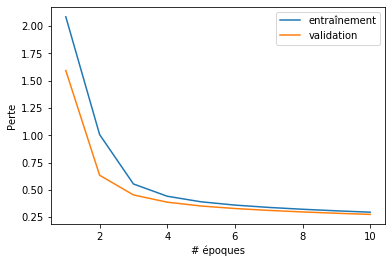

In [10]:
# Conserver l'historique pour plus tard
mlp_train_loss_history = train_loss_history
mlp_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='entraînement')
plt.plot(x, mlp_valid_loss_history, label='validation')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

## Tester le réseau
### Boîte à outils
On évalue ensuite le réseau sur l'ensemble du jeu de données d'évaluation.
### Implémentation

In [14]:
# Activer le mode d'évaluation
model.eval()

correct = 0
total = 0

# itération sur les données d'évaluation
for images, labels in test_loader:
    
    # transférer les données sur l'appareil choisi
    images = images.to(device)
    labels = labels.to(device)
    
    # Aplatir les images
    images = images.view(-1, 28*28)
    

    # propagation avant sur les images
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistiques
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print("Exactitude sur l'ensemble d'évaluation: {:.2f}%".format(100 * correct // total))

Exactitude sur l'ensemble d'évaluation: 92.00%


# Réseaux de neurones convolutifs (CNN/RNC)




## Concepts

Nous revisitons ici certains concepts de base pour les réseaux convolutifs.

### Convolution

Une convolution consiste à prendre un filtre *k* et le faire "glisser" le long de l'entrée *I* afin d'obtenir une sortie *I*\**K*.

Un exemple de convolution 2D:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/numerical_no_padding_no_strides.gif?raw=true)


### Filtres

Les filtres (*kernel*) sont utilisés afin d'extraire l'information utile des entrées. Ils ont généralement une taille *n* \* *n* avec *n* en général impair. La valeur des poids du filtre sont les paramètres qui seront appris par le réseau convolutif. 

Le filtre utilisé dans l'exemple de convolution précédent est:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/d7acc4aeb74d9e9cb5fb51482a302196594837fe.png?raw=true)

### Profondeur

On utilise en général un nombre *M* de filtres qui correspondra à la profondeur de la couche. La profondeur en soit est un hyperparamètre du réseau. Ici, chaque filtre (cercles bleu), contribue à une couche de profondeur de l'image en sortie.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/Conv_layer.png?raw=true)

### Foulée

La foulée, ou *stride*, correspond à la taille du pas (mesuré en pixels) effectué lors de l'opération de la convolution. On emploie généralement une foulée de 1 ou 2. Plus la foulée est élevée, plus la dimension en sortie sera réduite.

### Marge à zéro

La marge à zéro, ou *zero padding*, consiste à ajouter une bordure de zéros autour de l'entrée. Ceci peut être utile, par exemple, lorsqu'on souhaite préserver la dimension de l'entrée à la sortie.

Voici un exemple de marge à zéro qui préserve la taille de l'entrée à la sortie. Ici, la marge à zéro=1, foulée=1, et le filtre est de taille 3x3.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/same_padding_no_strides.gif?raw=true)



### Mise en commun maximale

Il est commun de retrouver dans les réseaux convolutifs des couches de mise en commun(*pooling*). Le but de la mise en commun est de réduire la dimension des entrées entres couches de convolutions afin de réduire le nombre de paramètres nécessaires du réseau. Dans le cas de LeNet, nous nous servons d'une mise en commun maximale avec taille de filtre 2x2 et foulée de 2. Ceci consiste à prendre la valeur maximale d'une région 2x2 puis de s'en servir comme entrée à la prochaine couche.

Voici un exemple de mise en commun maximale:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/maxpool.jpeg?raw=true)


### Champ réceptif

Le champ réceptif, ou *Receptive Field*, est une mesure de la capacité du réseau à percevoir les détails à différentes échelles de l'entrée.  Dans un MLP, toutes les entrées sont connectés (*fully connected*), donc le champ réceptif est la totalité de l'image. Dans le cas d'un réseau convolutif, plus il y a de filtres successifs, plus nous ajoutons au champ réceptif. Considérons le cas simple d'un filtre 3x3 avec stride=1. Dans ce cas, pour un réseau à une couche, notre champ réceptif est au maximum de 3x3. Cependant, plus nous ajoutons de couches, plus nous augmentons notre champ réceptif. En ajoutant une seconde couche 3x3 avec foulée de 1, notre champ réceptif augmente a 5x5. En ajoutant une 3ème couche 3x3, notre champ réceptif effectif est de 7x7. En utilisant 3 filtres 3x3 successifs, notre réseau necessite 3x3x3=27 paramètres, tandis qu'un seul filtre de taille 7x7 requiert 49 paramètres. Il est donc plus optimal d'utliser plusieurs filtres successifs qu'un seul gros filtre pour un champ réceptif équivalent. Également, en utilisant plusieurs filtres successifs, nous pouvons introduire plusieurs non-linéarités dans notre modèle.

Ici, le filtre de taille 3x3 (bordures grises) avec foulée de 1 a un champ réceptif de 5x5 (région jaune)

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/sNBmKMKAz-yJeCuS14usSqw.png?raw=true)


### Calculs de dimensions

De façon générale, pour une couche de convolution avec entrée de dimension du volume
$W_1 * H_1 * D_1$ et avec les hyperparamètres

* Nombre de filtres = $K$

* Taille de filtre = $F$

* Taille de foulée $S$

* Taille de marge $P$

Nous obtenons un volume en sortie de $W_2 * H_2 * D_2$ où 

* $W_2 = (W_1 - F + 2P) / S + 1$
* $H_2 = (H1 - F + 2P) / S + 1$
* $D_2 = K$

avec un nombre de paramètres total de $(F⋅F⋅D_1)⋅K$ poids et $K$ biais.

Pour une analyse plus détaillée, consultez [cet article](http://cs231n.github.io/convolutional-networks/).


## LeNet
LeNet est un réseau convolutif simple pour la classification. Il en existe plusieurs versions. Il est préférable d'utiliser un réseau convolutif pour de la classification d'images car ce type de réseau prend en compte la structure de l'image et à taille de réseau équivalent a un nombre de paramètres plus faible.

Par exemple, si on prend l'exemple de LeNet 5 pour classifier les images de chiffres du jeu de données MNIST :

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/lenet5.png?raw=true)


La procédure d'apprentissage typique pour ce modèle est la même que pour le perceptron multi-couche et consiste à :
<ul>
<li>Définir l'architecture du réseau. Cela définira les paramètres (poids et biais) du réseau.</li>
<li>Définir la fonction de coût et l'optimiseur.</li>
<li>Entraîner le réseau.</li>
<li>Tester le réseau.</li>
</ul>


## Définir l'architecture du réseau
### Boîte à outils
**Rappel :** Pour définir l'architecture du réseau en pytorch il faut créer une classe enfant de la classe parent <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Module">`torch.nn.Module`</a> où les méthodes suivantes sont à compléter :
<ul>
<li>La méthode `__init__` qui définit les couches. </li>
<li>La méthode `forward(input)` qui retourne la sortie.</li>
</ul>

Pour construire les couches de l'`__init__` de LeNet 5, les classes suivantes peuvent être utilisées :
<ul>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Conv2d">`torch.nn.Conv2d(canaux_en_entrée, canaux_en_sortie, taille_du_filtre)`</a> qui applique une convolution 2D sur un signal d'entrée composé de plusieurs canaux d'entrée.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d">`torch.nn.MaxPool2d(taille_du_filtre)`</a> qui applique une mise en commun maximale 2D sur un signal d'entrée composé de plusieurs canaux d'entrée.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(canaux_en_entrée, canaux_en_sortie)`</a> qui applique une transformation linéaire aux données d'entrée : y = Ax + b.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.ReLU">`torch.nn.Relu()`</a> qui applique la fonction Relu éléments par éléments : Relu(x) = max(0, x).</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Softmax">`torch.nn.Softmax(dim)`</a> qui applique la fonction Sofmax à un tenseur d'entrée à n-dimensions en le normalisant de tel sorte que les éléments de tenseur de sortie à n-dimension soient dans l'intervalle [0, 1] et somment à 1.</li>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Sequential">`torch.nn.sequential`</a>  qui est un conteneur séquentiel dans lequel les modules sont ajoutés dans l'ordre dans lequel ils sont passés au constructeur.</li>
</ul>

Dans `forward(input)` on applique aux données d'entrée les différentes couches définies dans `__init__` les unes après les autres.
Il est aussi nécessaire de changer la forme des données juste avant l'appel à la couche linéaire, celle-ci n'acceptant que des données uni-dimensionelles. Il est possible d'utiliser <a href="https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view">`torch.Tensor.view(new_shape)`</a> pour cela.

Enfin, `model.to("cuda:0")` permet de passer le modèle sur GPU.

### Implémentation

In [18]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.block1(x)

        out = self.block2(out)
        
        # aplatir la sortie de block2
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        
        return out
        
model = LeNet5()
model = model.to(device)

print(model)
print("\n\n# paramètres: ", sum([param.nelement() for param in model.parameters()]))

LeNet5(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# paramètres:  28938


 Ici, on observe 28 938 paramètres pour LeNet5 contre 648 010 paramètres pour le MLP à deux couches cachées. On a donc une réduction significative du nombre de paramètres entre LeNet5 et le MLP précédent. Le calcul du nombre de paramètres se résume ainsi:
 


```
1ère couche: 16 filtres de taille 5x5 + 16 biais = 16*5*5 + 16 = 416
2ème couche: 16 * 32 filtres de taille 5x5 + 32 biais = 16*32*5*5 + 32 = 12 832
Couche entièrement connectée: 7*7*32*10 + 10 biais = 15 690
 
Total = 416 + 12 832 + 15 690 = 28 938
```



In [19]:
# Sauvegarder les poids initiaux du modèle
init_model_wts = copy.deepcopy(model.state_dict())

## Définir la fonction de coût et l'optimiseur
### Boîte à outils
**Rappel : ** un choix commun pour un problème de classification (notre cas) est d'utiliser les classes suivantes :
<ul>
<li>**Fonction de coût :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. L'entropie croisée est souvent utilisée en optimisation. Elle permet de comparer une distribution $p$ avec une distibution de référence $t$. Elle est minimum lorsque $t=p$. Sa formule pour la calculer entre la prédiction et la cible est : $-\sum_j t_{ij} \log(p_{ij})$ où $p$ est la prédiction, $t$ la cible, $i$ les exemples et $j$ les classes de la cible.</li>
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a> qui est une implémentation de SGD.</li>
</ul>

### Implémentation


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Entraîner le réseau
### Boîte à outils
**Rappel :** en général, l'entraînement d'un réseau se fait en itérant sur plusieurs époques (une époque correspond à une passe sur l'intégralité du jeu de données d'entraînement). Sur une époque on va recevoir une série de lots fournis par l'itérateur. Pour chaque lot, on fait les opérations suivantes:
<ul>
<li>`optimizer.zero_grad()` : on efface les gradients encore stockés par le réseau issus de la passe précédente.</li>
<li>`loss.backward()` : on calcule automatiquement la dérivée du coût et on propage l'erreur dans le graphe par rétro-propagation.</li>
<li>`optimizer.step()` : on effectue une étape de descente de gradient. Dans le cas de SGD, c'est une descente de gradient classique avec les gradients calculés précédemment : `poids = poids - pas_d_apprentissage * gradient`.</li>
</ul>

### Implémentation
Complétez les trous pour entraîner le réseau.

Bonne chance !

In [21]:
model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Début de l'entraînement #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # activer le mode d'entraînement
    model.train()
    
    # itération sur les données d'entraînement
    for images, labels in train_loader:  

        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # réinitialiser les gradients à zéro
        optimizer.zero_grad()  
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # rétropropagation
        loss.backward()
        
        # optimisation
        optimizer.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # activer le mode d'évaluation
    model.eval()
    
    # itération sur les données de validation
    for images, labels in valid_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Statistiques
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nÉpoque: {}/{}'.format(epoch + 1, num_epochs))
    print("\tPerte d'entraînement: {:.4f}".format(train_loss / train_n_iter))
    print("\tPerte de validation: {:.4f}".format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Début de l'entraînement #

Époque: 1/10
	Perte d'entraînement: 1.2142
	Perte de validation: 0.4011

Époque: 2/10
	Perte d'entraînement: 0.3169
	Perte de validation: 0.2552

Époque: 3/10
	Perte d'entraînement: 0.2295
	Perte de validation: 0.1936

Époque: 4/10
	Perte d'entraînement: 0.1827
	Perte de validation: 0.1586

Époque: 5/10
	Perte d'entraînement: 0.1527
	Perte de validation: 0.1362

Époque: 6/10
	Perte d'entraînement: 0.1322
	Perte de validation: 0.1208

Époque: 7/10
	Perte d'entraînement: 0.1174
	Perte de validation: 0.1097

Époque: 8/10
	Perte d'entraînement: 0.1063
	Perte de validation: 0.1014

Époque: 9/10
	Perte d'entraînement: 0.0977
	Perte de validation: 0.0950

Époque: 10/10
	Perte d'entraînement: 0.0907
	Perte de validation: 0.0899


Entraînement fini en 3m 59s


Visualisons les courbes d'entraînement !

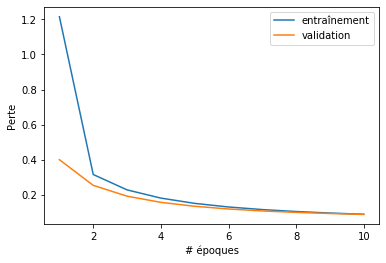

In [22]:
# Conserver l'historique pour plus tard
lenet5_train_loss_history = train_loss_history
lenet5_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
x = range(1, num_epochs + 1)
plt.plot(x, lenet5_train_loss_history, label='entraînement')
plt.plot(x, lenet5_valid_loss_history, label='validation')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

On peut superposer les courbes d'entraînement et de validation de LeNet5 et du MLP :

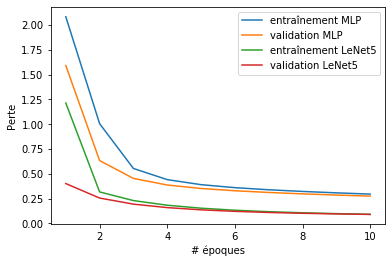

In [23]:
# Plot training and validation curve
x = range(1, num_epochs + 1)
plt.plot(x, mlp_train_loss_history, label='entraînement MLP')
plt.plot(x, mlp_valid_loss_history, label='validation MLP')
plt.plot(x, lenet5_train_loss_history, label='entraînement LeNet5')
plt.plot(x, lenet5_valid_loss_history, label='validation LeNet5')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

## Tester le réseau
### Boîte à outils
**Rappel :** on évalue ensuite le réseau sur l'ensemble du jeu de données d'évaluation.
### Implémentation

In [25]:
# Activer le mode d'évaluation
model.eval()

correct = 0
total = 0

# itération sur les données d'évaluation
for images, labels in test_loader:
    
    # transférer les données sur l'appareil choisi
    images = images.to(device)
    labels = labels.to(device)
    
    # Pas besoin d'aplatir les images ici !
    

    # propagation avant sur les images
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistiques
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print("Exactitude sur l'ensemble d'évaluation: {:.2f}%".format(100 * correct // total))

Exactitude sur l'ensemble d'évaluation: 97.00%


On obtient de meilleurs résultats après 10 époques !

---



## Méthodes pratiques pour améliorer l'entraînement

### Normalisation par lots (Batch Normalization)
La normalisation par lots est une astuce qui permet, en pratique, au modèle d'apprendre plus vite. Elle agit comme régularisateur en normalisant les entrées par batch, de manière différentiable. Les données en sorties de cette couche auront une moyenne proche de 0 et une variance proche de 1.

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_Hiq-rLFGDpESpr8QNsJ1jg.png?raw=true)


Pour plus d'informations sur la *normalisation par lots*, consultez cet [article](https://arxiv.org/pdf/1502.03167v3.pdf).

### Boîte à outils
Pour ajouter la normalisation par lots dans LeNet5, il suffit de l'ajouter parmis les couches de l'`__init__` et de l'appeler après chaque couche de convolution. La classe suivante peut être utilisée:
<ul>
<li><a href="http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d">`nn.BatchNorm2d(num_features)`</a> : permet d'ajouter de la normalisation par lots à une entrée à 4 dimensions présentée sous la forme d'un tenseur à 3 dimensions.</li>
</ul>

### Implémentation


In [26]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.block1(x)

        out = self.block2(out)
        
        # Aplatir la sortie du bloc2
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        
        return out
        
model = LeNet5()
model = model.to(device)
  
print(model)

print("\n\n# paramètres: ", sum([param.nelement() for param in model.parameters()]))

LeNet5(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# paramètres:  29034


Ici, on observe 29 034 paramètres pour LeNet5 avec normalisation par lots contre 28 938 paramètres pour LeNet5 sans normalisation par lots.

In [27]:
# Sauvegarder les poids initiaux du modèle
init_model_wts = copy.deepcopy(model.state_dict())

**L'implémentation de la fonction de coût, l'optimiseur, les boucles d'entraînement et de test du réseau reste inchangé !**

In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.load_state_dict(init_model_wts)

since = time.time()

num_epochs = 10
train_loss_history = []
valid_loss_history = []

print("# Début de l'entraînement #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # activer le mode d'entraînement
    model.train()
    
    # itération sur les données d'entraînement
    for images, labels in train_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)

        # réinitialiser les gradients à zéro
        optimizer.zero_grad()  
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # rétropropagation
        loss.backward()
        
        # optimisation
        optimizer.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # activer le mode d'évaluation
    model.eval()
    
    # itération sur les données de validation
    for images, labels in valid_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Statistiques
        valid_loss += loss.item()
        valid_n_iter += 1
    
    train_loss_history.append(train_loss/train_n_iter)
    valid_loss_history.append(valid_loss/valid_n_iter)
        
    print('\nÉpoque: {}/{}'.format(epoch + 1, num_epochs))
    print("\tPerte d'entraînement: {:.4f}".format(train_loss / train_n_iter))
    print("\tPerte de validation: {:.4f}".format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# activer le mode d'évaluation
model.eval()

correct = 0
total = 0

# itération sur les données
for images, labels in test_loader:
  

    # transférer les données sur l'appareil choisi
    images = images.to(device)
    labels = labels.to(device)
    
    # Pas besoin d'aplatir les images ici !
   
    
    # propagation avant
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistiques
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print("\n\nExactitude sur l'ensemble d'entraînement: {:.2f}%".format(100 * correct // total))

# Début de l'entraînement #

Époque: 1/10
	Perte d'entraînement: 0.3032
	Perte de validation: 0.1341

Époque: 2/10
	Perte d'entraînement: 0.1073
	Perte de validation: 0.0937

Époque: 3/10
	Perte d'entraînement: 0.0784
	Perte de validation: 0.0777

Époque: 4/10
	Perte d'entraînement: 0.0643
	Perte de validation: 0.0690

Époque: 5/10
	Perte d'entraînement: 0.0556
	Perte de validation: 0.0632

Époque: 6/10
	Perte d'entraînement: 0.0495
	Perte de validation: 0.0592

Époque: 7/10
	Perte d'entraînement: 0.0449
	Perte de validation: 0.0563

Époque: 8/10
	Perte d'entraînement: 0.0413
	Perte de validation: 0.0540

Époque: 9/10
	Perte d'entraînement: 0.0383
	Perte de validation: 0.0519

Époque: 10/10
	Perte d'entraînement: 0.0357
	Perte de validation: 0.0503


Entraînement fini en 5m 17s


Exactitude sur l'ensemble d'entraînement: 98.00%


On obtient d'encore meilleurs résultats après 10 époques !

Regardons les coubres d'entraînement et de validation :

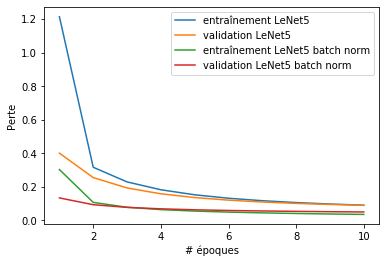

In [30]:
# Conserver l'historique pour plus tard
lenet5_batchnorm_train_loss_history = train_loss_history
lenet5_batchnorm_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
x = range(1, num_epochs + 1)
plt.plot(x, lenet5_train_loss_history, label='entraînement LeNet5')
plt.plot(x, lenet5_valid_loss_history, label='validation LeNet5')
plt.plot(x, lenet5_batchnorm_train_loss_history, label='entraînement LeNet5 batch norm')
plt.plot(x, lenet5_batchnorm_valid_loss_history, label='validation LeNet5 batch norm')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

# Apprentissage par transfert : réglage fin d'un réseau convolutif
**Attribution :** cette partie reprend en partie le tutoriel : http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

En pratique, il est peu commun d'entraîner un réseau convolutif à partir de rien (c'est-à-dire avec une initialisation aléatoire des poids). En effet, souvent, le jeu de données d'intérêt est trop petit. A la place, il est commun de pré-entraîner le réseau sur un jeu de données plus gros comme, par exemple, un sous-ensemble d'ImageNet (1.2 millions d'images avec 1000 catégories). Ce réseau pré-entraîné est ensuite utilisé comme initialisation des poids du réseau qui sera entraîné sur le jeu de données d'intérêt. On parle de réglage fin du réseau convolutif. A noter que le réseau pré-entraîné peut aussi être utilisé pour extraire de nouvelles variables du jeu de données d'intérêt. On parle d'apprentissage par transfert.

Nous allons maintenant étudier plus en détail le scénario du réglage fin pour l'apprentissage par transfert.

## Télécharger les données et créer le chargeur de données
Le jeu de données que nous allons étudier est un sous-ensemble d'ImageNet qui contient environ $120 \times 2$ images d'entraînement et $75 \times 2$ images d'évaluation de fourmis et d'abeilles. Le but est de classifier ces deux classes. Ci-dessous, un exemples d'images de ce jeu de données :


![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/fourmi_abeille.png?raw=true)

### Boîte à outils
**Rappel :** une façon simple de charger les données dans PyTorch est : 
<ul>
<li>D'utiliser une classe enfant de la classe parent <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset">`torch.utils.data.Dataset`</a> où les méthodes `__getitem__` et `__len__` sont à compléter. Notez qu' à ce stade, les données ne sont pas chargées en mémoire.</li>
<li>D'utiliser la classe <a href="http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader">`torch.utils.data.DataLoader`</a> pour lire et mettre en mémoire les données.</li>
</ul>

**Remarque :** <a href="http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets">`torchvision.datasets`</a> peut aussi être utilisé pour charger des données à partir d'un dossier.

**Augmentation des données :** pour augmenter les données, <a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision-transforms">`torchvision.transforms`</a> fournit les transformations d'images courantes. Ces transformations peuvent être appliquées successivement en utilisant la classe <a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Compose">`torchvision.transforms.Compose`</a>.

### Implémentation

In [31]:
%%bash
## télécharger l'ensemble de données ##
if [ ! -d "hymenoptera_data" ]; then
  wget --quiet https://download.pytorch.org/tutorial/hymenoptera_data.zip
  unzip -q hymenoptera_data.zip
  rm hymenoptera_data.zip
fi

In [32]:
import os
from PIL import Image
from torchvision import datasets


def make_dataset(root, split_type):
    """
    Paramètres
    ----------
    root_dir : string
    Répertoire avec toutes les images.
    split_type : chaîne de caractères
    Le nom de la partition dans {"train", "valid"}.

    Retourne
    -------
    images : dict
    Dictionnaire d'images pour chaque classe pour 
        un type de partition spécifique.    
    """

    images = {}
    root = os.path.join(root, split_type)

    for classes in sorted(os.listdir(root)):
        images[classes] = []
    path_classes = os.path.join(root, classes)

    for root_, _, fnames in sorted(os.walk(path_classes)):
        for fname in sorted(fnames):
            if fname.endswith('.jpg'):
                item = os.path.join(root_, fname)
                images[classes].append(item)

    return images


class HymenopteraDataset(torch.utils.data.Dataset):
    """Ensemble de données Hymenoptera."""

    def __init__(self, root_dir, split_type='train', transform=None):
        """
        Paramètres
        ----------
        root_dir : string
           Répertoire avec toutes les images.
        split_type : chaîne de caractères
           Le nom de la partition dans {'train', 'valid', 'test', 'train_valid'}.
        transform : appelable, facultatif
           Transformation optionnelle à appliquer sur un échantillon.
        """
        self.root_dir = root_dir
        self.split_type = split_type
        self.transform = transform
        self.classes = {'ants': 0, 'bees': 1}

        imgs_ = []
        target_ = []

        if split_type == 'train':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k][:int(0.8*len(v))]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'valid':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k][int(0.8*len(v)):]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'train_valid':
            imgs = make_dataset(root_dir, 'train')
            for k, v in imgs.items():
                imgs_ += imgs[k]
                target_ += [self.classes[k]] * len(imgs_)

        elif split_type == 'test':
            imgs = make_dataset(root_dir, 'val')
            for k, v in imgs.items():
                imgs_ += imgs[k]
                target_ += [self.classes[k]] * len(imgs_)

        self.imgs = imgs_
        self.target = np.array(target_)

    def __len__(self):
        """
        Obtenez le nombre d'images dans l'ensemble de données.

        Retourne
        -------
        int
           Le nombre d'images dans l'ensemble de données.
        """
        return len(self.imgs)

    def __getitem__(self, index):
        """
        Obtenir les éléments : image, target

        Paramètres
        ----------
        index : int
           Index

        Retourne
        -------
        img : tenseur
           L'image.
        target : int
           La cible est l'indice de classe de la classe cible.
        """
        path = self.imgs[index]
        target = self.target[index]

        with open(path, 'rb') as f:
            with Image.open(f) as img:
                img.convert('RGB')

                if self.transform:
                    img = self.transform(img)

        return img, target


## Augmentation des données 
Une astuce souvent utilisée pour éviter l'overfit et augmenter la taille apparente du jeu de données d'entrainement est l'augmentation de données. Il s'agit de différents types de transformations aux entrées afin de déformer légèrement les images. Par exemple, les images peuvent être agrandies, élargies, tournées sur elle mêmes, miroitées, etc. Voici un exemple de différentes augmentations:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_Jujct_Pt-zvdWtSFpHUp3Q.png?raw=true)


Pour augmenter les données, <a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision-transforms">`torchvision.transforms`</a> fournit les transformations d'images courantes. Ces transformations peuvent être appliquées successivement en utilisant la classe <a href="http://pytorch.org/docs/master/torchvision/transforms.html#torchvision.transforms.Compose">`torchvision.transforms.Compose`</a>.

Ajoutez les transformations suivantes pour l'ensemble d'entraînement:
* Un recadrage (*crop*) aléatoire qui redimensionne l'image à une taille 224x224
* Une probabilité aléatoire de prendre une copie miroitée de l'image
* Une normalisation avec les valeurs suivantes pour les moyennes et écarts types: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

Pour l'ensemble de validation, redimensionnez l'image à 256x256, prenez un crop à partir du centre de l'image et normalisez l'image avec les mêmes valeurs que pour l'ensemble d'entraînement.


In [33]:
# Augmentation et normalisation des données pour l'entraînement
# Juste la normalisation pour la validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [34]:
# chargeur de l'ensemble de données
data_dir = 'hymenoptera_data'

data_train = HymenopteraDataset(data_dir, 'train', data_transforms['train'])
train_loader = DataLoader(data_train, batch_size=4, shuffle=True, num_workers=4)

data_valid = HymenopteraDataset(data_dir, 'valid', data_transforms['valid'])
valid_loader = DataLoader(data_valid, batch_size=4, shuffle=False, num_workers=4)

data_test = HymenopteraDataset(data_dir, 'test', data_transforms['valid'])
test_loader = DataLoader(data_test, batch_size=4, shuffle=False, num_workers=4)

print("# images dans l'ensemble d'entraînement: {}".format(len(data_train)))
print("# images dans l'ensemble de validation: {}".format(len(data_valid)))
print("# images dans l'ensemble d'évaluation: {}".format(len(data_test)))

# images dans l'ensemble d'entraînement: 96
# images dans l'ensemble de validation: 25
# images dans l'ensemble d'évaluation: 83


Visualisons les données d'entraînement !

Classes: {'ants': 0, 'bees': 1}
Taille des entrées: torch.Size([4, 3, 224, 224])
Taille des classes: torch.Size([4])


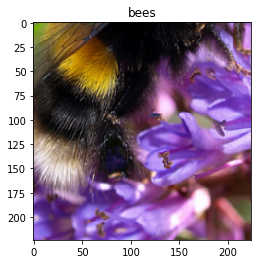

In [35]:
inputs, classes = next(iter(train_loader))

print('Classes: {}'.format(data_train.classes))
print('Taille des entrées: {}'.format(inputs.size()))
print('Taille des classes: {}'.format(classes.size()))

# Image aléatoire du lot
idx = np.random.randint(len(inputs))
img = inputs[idx]
labels = list(data_train.classes.keys())
img_label = labels[(classes[idx])]

img = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.title(img_label)
plt.grid(False)
plt.show()

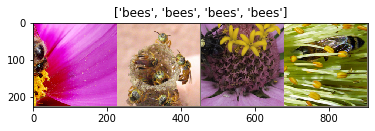

In [36]:
import torchvision

def imshow(img, title=None):
    """Imshow pour Tenseur."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.grid(False)
    plt.show()

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

class_names = data_train.classes
class_names = {class_names[k]: k for k in class_names.keys()}

imshow(out, title=[class_names[int(x)] for x in classes])

## Définir l'architecture du réseau
### Boîte à outils
Ici, nous voulons réutiliser un réseau pré-entrainé sur ImageNet. Pour cela, il faut charger un modèle pré-entraîné et réinitialiser la couche finale qui est la couche complètement connectée. Par chance, dans Pytorch, <a href="http://pytorch.org/docs/0.1.12/torchvision/models.html#module-torchvision.models">`torchvision.models`</a> propose des architectures toutes faites où les poids ont déjà été entraînés sur ImageNet.

Un choix commun pour un problème de classification (notre cas) est d'utiliser le modèle *ResNet18*. Pour plus d'informations sur cette architecture, consultez cet [article](https://arxiv.org/abs/1512.03385). Vous pouvez également consulter la documentation PyTorch du modèle:
<a href="http://pytorch.org/docs/0.1.12/torchvision/models.html#torchvision.models.resnet18">`torchvision.models.resnet18(pretrained=True)`</a>

Un exemple de bloc résiduel est donné ci-dessous :

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/bloc_residuel.png?raw=true)


**Rappel :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a> permet d'appliquer une transformation linéaire à des données d'entrée : y = Ax + b.

### Implémentation

Dans un premier temps on va utiliser un modèle non pré-entraîné puis on utilisera le même modèle mais cette fois-ci pré-entraîné afin de comparer les résultats.

In [37]:
from torchvision import models

# Charger un modèle de resnet18 non pré-entraîné
model = models.resnet18(pretrained=False)

# Réinitialisation de la dernière couche
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

print(model)

print("\n\n# paramètres: ", sum([param.nelement() for param in model.parameters()]))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# Sauvegarder les poids initiaux du modèle
init_model_wts = copy.deepcopy(model.state_dict())

## Définir la fonction de coût et l'optimiseur
### Boîte à outils
**Rappel : ** un choix commun pour un problème de classification (notre cas) est d'utiliser les classes suivantes :
<ul>
<li>**Fonction de coût :** <a href="http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss">`torch.nn.CrossEntropyLoss()`</a>. L'entropie croisée est souvent utilisée en optimisation. Elle permet de comparer une distribution $p$ avec une distibution de référence $t$. Elle est minimum lorsque $t=p$. Sa formule pour la calculer entre la prédiction et la cible est : $-\sum_j t_{ij} \log(p_{ij})$ où $p$ est la prédiction, $t$ la cible, $i$ les exemples et $j$ les classes de la cible.</li>
<li>**Optimiseur :** <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a>. Utilisez un taux d'apprentissage de 1e-3 et une valeur d'élan (<i>momentum</i>) de 0.9</li>
</ul>

### Implémentation

In [39]:
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Entraîner le réseau
### Boîte à outils
**Rappel :** en général, l'entraînement d'un réseau se fait en itérant sur plusieurs époques (une époque correspond à une passe sur l'intégralité du jeu de données d'entraînement). Sur une époque on va recevoir une série de lots fournis par l'itérateur. Pour chaque lot, on fait les opérations suivantes:
<ul>
<li>`optimizer.zero_grad()` : on efface les gradients encore stockés par le réseau issus de la passe précédente.</li>
<li>`loss.backward()` : on calcule automatiquement la dérivée du coût et on propage l'erreur dans le graphe par rétro-propagation.</li>
<li>`optimizer.step()` : on effectue une étape de descente de gradient. Dans le cas de SGD, c'est une descente de gradient classique avec les gradients calculés précédemment : `poids = poids - pas_d_apprentissage * gradient`. Dans le cas d'Adam une opération légérement plus complexe est réalisée.</li>
</ul>

**Conseils bonus :** Lorsque l'on entraîne le réseau de neurones profonds, il est conseillé de faire :
<ul>
<li>de l'arrêt précoce. C'est une forme de régularisation qui évite de faire du sur-apprentissage en utilisant une règle pour stopper l'apprentissage du modèle.</li>
<li>de l'attribution de points de contrôle (<i>checkpointing</i>). Pour cela, il est commun d'enregister les poids du réseau avec `model.state_dict()` à différentes étapes de l'entraînement.</li>
<li>d'imprimer les temps d'exécution. Pour cela, il est commun d'utiliser `time.time()`.</li>
</ul>

### Implémentation

In [41]:
import time

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 25
best_acc = 0.0

train_loss_history = []
valid_loss_history = []

print("# Début de l'entraînement #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # activer le mode d'entraînement
    model.train()
    
    # itération sur les données d'entraînement
    for images, labels in train_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)

        # réinitialiser les gradients à zéro
        optimizer.zero_grad()  
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # rétropropagation
        loss.backward()
        
        # optimisation
        optimizer.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Activer le mode d'évaluation
    model.eval()
    
    # itération sur les données de validation
    total = 0
    correct = 0
    for images, labels in valid_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # propagation avant sur les images
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
    
        # Statistiques
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        valid_loss += loss.item()
        valid_n_iter += 1
    
    epoch_acc = 100 * correct // total
    
    # Copie profonde du meilleur modèle
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nÉpoque: {}/{}'.format(epoch + 1, num_epochs))
    print("\tPerte d'entraînement: {:.4f}".format(train_loss / train_n_iter))
    print("\tPerte de validation: {:.4f}".format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('\n\nMeilleure exactitude de validation: {:.2f}'.format(best_acc))

# Début de l'entraînement #

Époque: 1/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0001

Époque: 2/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 3/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 4/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 5/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 6/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 7/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 8/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 9/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 10/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 11/25
	Perte d'entraînement: 0.0000
	Perte de validation: 0.0000

Époque: 12/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 13/25
	Perte d'entraînement: 0.0001
	Perte de validation: 0.0000

Époque: 14/25
	Per

Visualisons les courbes d'entraînement et de validation :

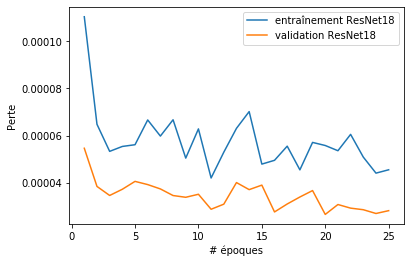

In [42]:
resnet18_train_loss_history = train_loss_history
resnet18_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
x = range(1, num_epochs + 1)
plt.plot(x, resnet18_train_loss_history, label='entraînement ResNet18')
plt.plot(x, resnet18_valid_loss_history, label='validation ResNet18')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

## Tester le réseau
### Boîte à outils
**Rappel :** on évalue ensuite le réseau sur l'ensemble du jeu de données d'évaluation.

**Remarque :** ici, nous n'avons pas de données d'évaluation donc nous testons sur l'ensemble de validation (à ne pas faire en pratique).

**Utilisation des poids du meilleur modèle :** comme nous avons fait de l'arrêt précoce lors de l'entraînement, nous voulons réutiliser les poids du meilleur modèle sur l'ensemble de validation pour tester le modèle. Ces poids ont été enregistrés lors de l'entraînement du modèle dans `best_model_wts`. Pour les charger il suffit d'utiliser `model.load_state_dict(best_model_wts)`.
### Implémentation

In [44]:
# Charger les poids du meilleur modèle
model.load_state_dict(best_model_wts)

# Activer le mode d'évaluation
model.eval()

correct = 0
total = 0

# itération sur les données d'évaluation
for images, labels in test_loader:
    
    # transférer les données sur l'appareil choisi
    images = images.to(device)
    labels = labels.to(device)
    
    # propagation avant sur les images
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistiques
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print("Exactitude sur l'ensemble d'évaluation: {:.2f}%".format(100 * correct // total))

Exactitude sur l'ensemble d'évaluation: 100.00%


Avec les poids pré-entraînés :

In [45]:
from torchvision import models

# Charger un modèle de resnet18 pré-entraîné
model = models.resnet18(pretrained=True)

# Réinitialisation de la dernière couche
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

print(model)

print("\n\n# paramètres: ", sum([param.nelement() for param in model.parameters()]))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/andrew/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [46]:
# Sauvegarder les poids initiaux du modèle
init_model_wts = copy.deepcopy(model.state_dict())

In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [48]:
since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 25
best_acc = 0.0

train_loss_history = []
valid_loss_history = []

print("# Début de l'entraînement #")
for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # activer le mode d'entraînement
    model.train()
    
    # itération sur les données d'entraînement
    for images, labels in train_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)

        # réinitialiser les gradients à zéro
        optimizer.zero_grad()  
        
        # propagation avant sur les images
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # rétropropagation
        loss.backward()
        
        # optimisation
        optimizer.step()
        
        # Statistiques
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Activer le mode d'évaluation
    model.eval()
    
    # itération sur les données de validation
    total = 0
    correct = 0
    for images, labels in valid_loader:  
        
        # transférer les données sur l'appareil choisi
        images = images.to(device)
        labels = labels.to(device)
        
        # propagation avant sur les images
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
    
        # Statistiques
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        valid_loss += loss.item()
        valid_n_iter += 1
    
    epoch_acc = 100 * correct // total
    
    # Copie profonde du meilleur modèle
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print('\nÉpoque: {}/{}'.format(epoch + 1, num_epochs))
    print("\tPerte d'entraînement: {:.4f}".format(train_loss / train_n_iter))
    print("\tPerte de validation: {:.4f}".format(valid_loss / valid_n_iter))

time_elapsed = time.time() - since

print('\n\nEntraînement fini en {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print('\n\nMeilleure exactitude de validation: {:.2f}'.format(best_acc))

# Début de l'entraînement #

Époque: 1/25
	Perte d'entraînement: 0.2126
	Perte de validation: 0.0589

Époque: 2/25
	Perte d'entraînement: 0.0417
	Perte de validation: 0.0258

Époque: 3/25
	Perte d'entraînement: 0.0235
	Perte de validation: 0.0141

Époque: 4/25
	Perte d'entraînement: 0.0170
	Perte de validation: 0.0128

Époque: 5/25
	Perte d'entraînement: 0.0129
	Perte de validation: 0.0078

Époque: 6/25
	Perte d'entraînement: 0.0104
	Perte de validation: 0.0086

Époque: 7/25
	Perte d'entraînement: 0.0084
	Perte de validation: 0.0066

Époque: 8/25
	Perte d'entraînement: 0.0072
	Perte de validation: 0.0063

Époque: 9/25
	Perte d'entraînement: 0.0065
	Perte de validation: 0.0061

Époque: 10/25
	Perte d'entraînement: 0.0058
	Perte de validation: 0.0048

Époque: 11/25
	Perte d'entraînement: 0.0063
	Perte de validation: 0.0042

Époque: 12/25
	Perte d'entraînement: 0.0049
	Perte de validation: 0.0036

Époque: 13/25
	Perte d'entraînement: 0.0046
	Perte de validation: 0.0036

Époque: 14/25
	Per

Visualisons les courbes d'entraînement et de validation :

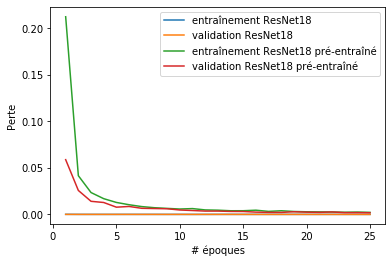

In [49]:
resnet18_pretrained_train_loss_history = train_loss_history
resnet18_pretrained_valid_loss_history = valid_loss_history

# Tracer les courbes d'entraînement et de validation
x = range(1, num_epochs + 1)
plt.plot(x, resnet18_train_loss_history, label='entraînement ResNet18')
plt.plot(x, resnet18_valid_loss_history, label='validation ResNet18')
plt.plot(
      x, resnet18_pretrained_train_loss_history,
    label='entraînement ResNet18 pré-entraîné')
plt.plot(
      x, resnet18_pretrained_valid_loss_history,
    label='validation ResNet18 pré-entraîné')

plt.xlabel('# époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

Testons le modèle :

In [50]:
# Charger les poids du meilleur modèle
model.load_state_dict(best_model_wts)

# Activer le mode d'évaluation
model.eval()

correct = 0
total = 0

# itération sur les données d'évaluation
for images, labels in test_loader:
    
    # transférer les données sur l'appareil choisi
    images = images.to(device)
    labels = labels.to(device)
    
    # propagation avant sur les images
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Statistiques
    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)

print("Exactitude sur l'ensemble d'évaluation: {:.2f}%".format(100 * correct // total))

Exactitude sur l'ensemble d'évaluation: 100.00%


On observe une augmentation de l'exactitude sur l'ensemble d'évaluation par rapport au modèle dont les poids n'avaient pas été entraîné.

# Suite (optionnelle)

Si vous souhaitez approfondir vos connaissances sur les réseaux convolutifs, voici une série de liens vers divers méthodes traitant sur des applications plus avancées.

## Segmentation d'image

Bien qu'il soit pratique de pouvoir classifier une image, il est encore plus pratique de pouvoir classifier quelle partie de l'image contient la catégorie en question par pixel. Il s'agit de la segmentation d'image. Un exemple populaire est l'algorithme [Mask R-CNN](https://arxiv.org/abs/1703.06870). Vous pouvez trouver un tutoriel sur l'implémentation de cet algorithme [ici](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb).

Voici un exemple d'image segmentée par catégrorie:

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/detection_final.png?raw=true)


## Modèles génératifs (exemple des RAG/GAN)

Un réseau antagoniste génératif (RAG/GAN) consiste de deux réseaux qui se font concurrence. Ils ont pour but de se surpasser l'un l'autre. Un réseau génère des images fictives et tente de convaincre l'autre réseau du réalisme de l'image tandis que l'autre réseau est entrainé à discerner une vraie image d'une fausse. Ceci permet la génération d'images réalistes lorsque les deux réseaux sont bien entrainés. Vous pouvez trouver la publication originale [ici](http://papers.nips.cc/paper/5423-generative-adversarial-nets) ainsi qu'une implémentation [ici](https://github.com/diegoalejogm/gans).

Voici un exemple de RAG sur MNIST: 

![Alt Text](https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/CNN/images/1_nAVqFluPijpBWR2tI4gCxg.png?raw=true)


# Références
Certaines parties de ce tutoriel sont fortement inspirées des tutoriaux suivant :
<ul>
<li>https://github.com/andrewliao11/dni.pytorch/blob/master/mlp.py
<li>https://github.com/andrewliao11/dni.pytorch/blob/master/cnn.py
<li>http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
<li>http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
 <li>http://cs231n.github.io/convolutional-networks/
 <li>http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#convolution-as-a-matrix-operation
</ul>